In [16]:
import os
import torch
import torchvision

import numpy as np
import pandas as pd
import seaborn as sns

from PIL import Image
from matplotlib import pyplot as plt

# Data first look

In [17]:
# get labels

labels_list = []
train_imgs = os.listdir('data/train')

for f in train_imgs:
    
    # 0 for 'cat', 1 for 'dog'
    if f.split('.')[0] == 'cat':
        labels_list.append(0)

    elif f.split('.')[0] == 'dog':
        labels_list.append(1)

    else:
    # if no label 
        labels_list.append(-1)

print(f'Images count = {len(train_imgs)}\nLabels count = {len(labels_list)}')

Images count = 25000
Labels count = 25000


In [18]:
df_train = pd.DataFrame(columns= ['image', 'label'])
df_train['image'] = train_imgs
df_train['label'] = labels_list

df_train.head(3)

,image,label
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0


In [19]:
df_train['label'].unique()

array([0, 1], dtype=int64)

<AxesSubplot:xlabel='label', ylabel='count'>

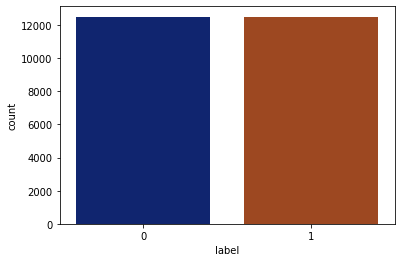

In [20]:
sns.countplot(data= df_train, x= 'label', palette= 'dark')

# Implementing self-made CNN model